In [1]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import matplotlib.pyplot as plt
from scarlet2 import *
import optax
from tqdm.auto import tqdm
import pandas as pd

/Users/mattsampson/miniconda3/envs/scorenet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#!pip install galaxygrad==0.0.4

In [4]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #

# read in the single test galaxy from HSC
data = pd.read_pickle('data_test.pkl')

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

images = multi_images 
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )

frame_psf = GaussianPSF(jnp.array((0, 0.2)), 0.7)
model_frame = Frame(Box(images.shape), psf=frame_psf)

# ----------------------------------- #
#      make one obs per image         #
#    model frame should be the same   #
# ----------------------------------- #
weights = 1/multi_var 
psf = multi_psf
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
obs.match(model_frame);
print('----------------------------------------')
print(f"    Scene contains {len(centers)} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 6 galaxy sources
----------------------------------------


In [5]:
# define initial circular model for initial morphology estimate 
# define initial circular model for initial morphology estimate 
from skimage import draw

# empty list
morph_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = .25 # noise factor

for i, bx in enumerate(box_size):
    arr = np.zeros((bx, bx))
    rr, cc = draw.disk((bx/2, bx/2), radius=bx/15, shape=arr.shape)
    arr[rr, cc] = 1
    noise = random.normal(key, (box_size[i], box_size[i]))
    raw =  sigma * noise #(jnp.array(arr) + sigma * noise)          # MATT EDIT THIS LINE
    normed = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))
    morph_init[i] = normed

In [6]:
# Load up the Scene with constraints and prior selected (no prior here)
keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene:
    for i in range(len( centers )):
        Source(
            centers[i],
            ArraySpectrum(random.normal(keys[0], (5,)), constraint=PositiveConstraint()),
            ArrayMorphology(morph_init[i], prior=NNPrior())
        )

In [7]:
spec_init = scene.sources

In [8]:
# need this to determine how many bands
# called src_num but actually band_number
src_num = len( centers )

# add in each observation here for Charlotte testing
obs_list = [obs]

# ------------------ #
# main train routine #
# ------------------ #
@eqx.filter_value_and_grad
def loss_fn_with_grad(model, obs_list, weight):
    prior = 0.0
    sources = model()
    neg_log_like = 0 #-obs.log_likelihood(sources)
    for idx in range(len(obs_list)):
        obs_x = obs_list[idx]
        neg_log_like += -obs_x.log_likelihood(sources)
    # likely want to use the same sources but on the other observation
    for i in range(src_num):
        prior += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  neg_log_like - prior  

def make_step(model, obs_list, opt_state, weigth):
    loss, grads = loss_fn_with_grad(model, obs_list, weigth)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, grads, model, opt_state

# hyperparameters for gradient optimiser
learning_rate= 3e-1 # alter this if desired
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(scene, eqx.is_array))
best_loss = 1e20
iters = 250
weight = 20.0  # this controls how strong the neural net grads are

# fitting routine
pbar = tqdm(range(iters), desc='fitting sources')
for step in pbar:
    loss, grads, scene, opt_state = make_step(scene, obs_list, opt_state, weight)
    loss = loss.item()
    pbar.set_description(f" fitting sources ==>  step: {step} loss: {loss}")

print(f"final step={step} loss={loss}")

 fitting sources ==>  step: 249 loss: 95865.6875: 100%|██████████| 250/250 [00:37<00:00,  6.63it/s]    

final step=249 loss=95865.6875


In [9]:
# make a poor stretching routine for better visuals
import cmasher as cmr
# TODO: Make proper normalising and stretching routine like the Lupton one
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import ImageNormalize
stretch = LinearStretch(slope=0.5, intercept=0.5) + SinhStretch() + \
    LinearStretch(slope=1, intercept=-1)
norm = ImageNormalize(stretch=stretch, vmin=0, vmax=2)
int_method='none'
cmap = cmr.lilac # the coolest cmasher colour

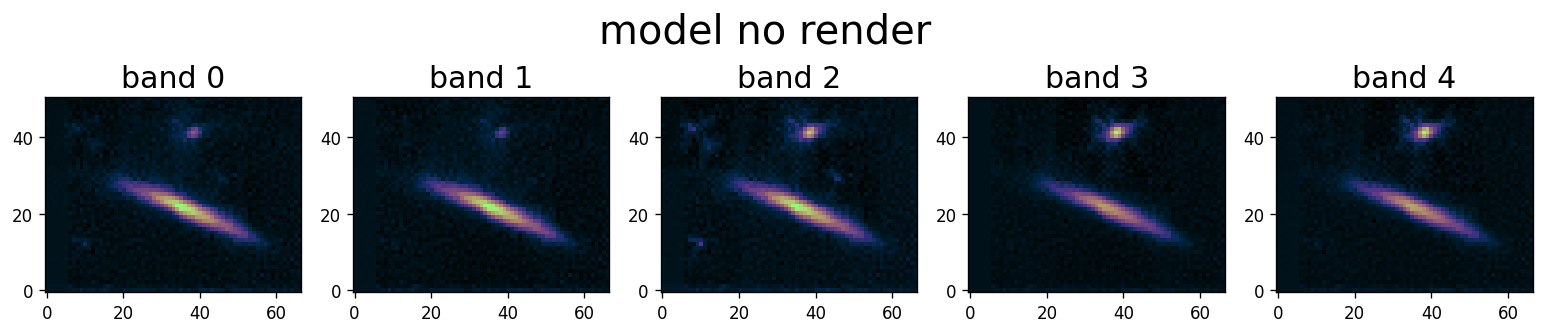

In [10]:
# create some plots to see how the sources look
sources = scene()
fig, axes = plt.subplots(1, sources.shape[0], figsize=(16,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(sources[i], cmap = cmap, interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('model no render', fontsize=24,y=0.75)
plt.show()

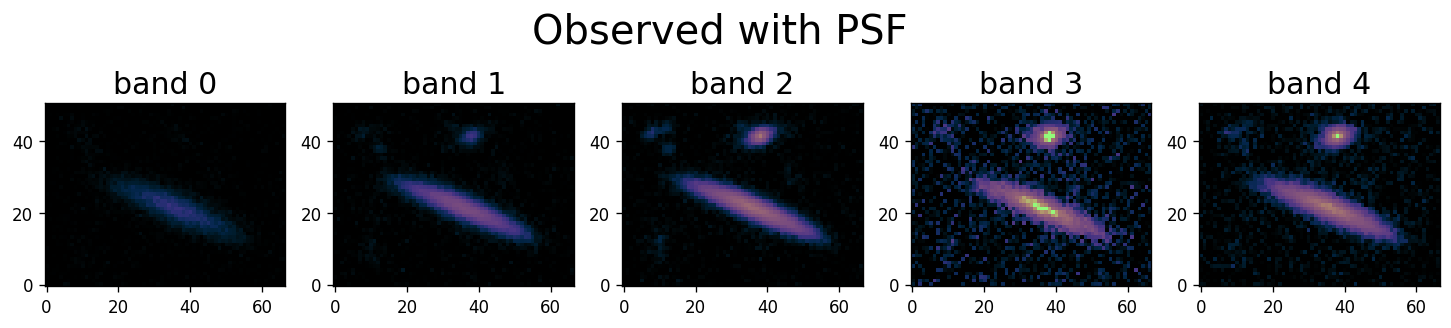

In [11]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('Observed with PSF', fontsize=24,y=0.75)
plt.show()

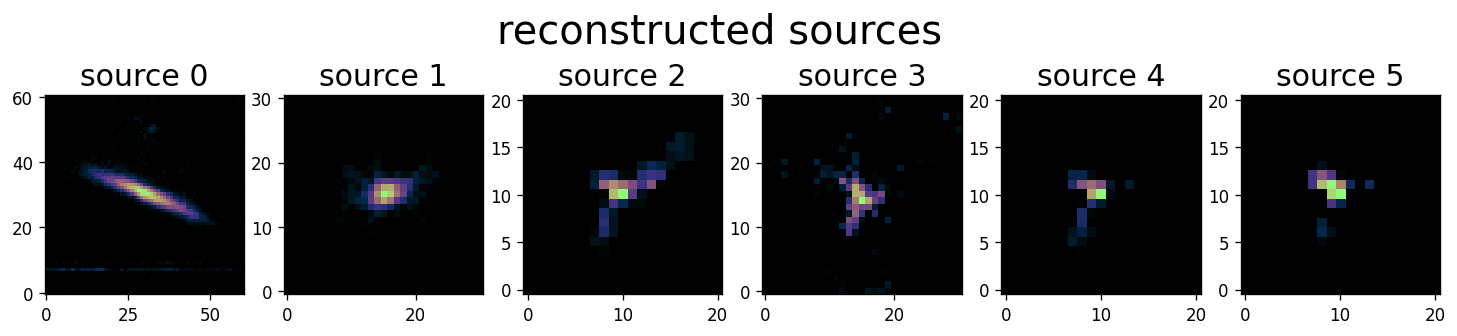

<Figure size 640x480 with 0 Axes>

In [20]:
# These should look far more like actual galaxies with the neural network acting as a constraint

fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene.sources[i].morphology() 
    ax.imshow(y, cmap = cmap, interpolation=int_method)
    ax.imshow(y, cmap = cmap, vmin=0, interpolation=int_method)
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources', fontsize=24,y=0.75)
plt.show()
plt.clf()

In [13]:
y = scene.sources[1].morphology() 
np.min(y)
# TODO: fix this in training of prior

Array(-0.34638554, dtype=float32)

In [14]:
# make renders
renders = obs.render(scene())

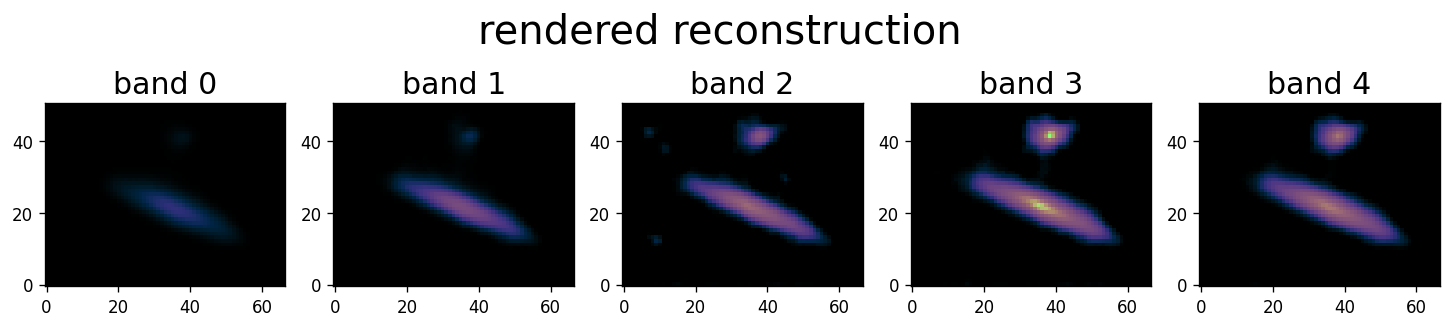

<Figure size 640x480 with 0 Axes>

In [15]:
fig, axes = plt.subplots(1, len( renders ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = renders[i]
    ax.imshow(y, cmap = cmap,norm=norm,interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('rendered reconstruction', fontsize=24,y=0.75)
plt.show()
plt.clf()

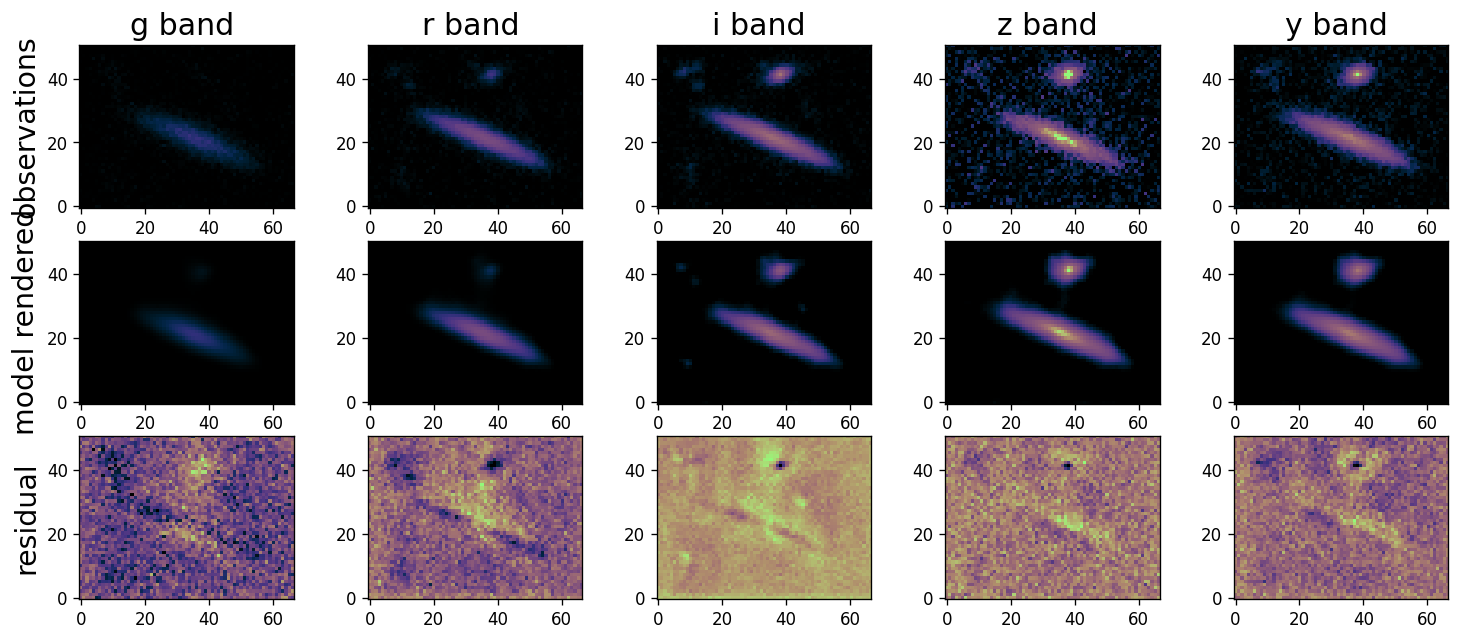

In [16]:
# plot full comparison
band_list = ['g', 'r', 'i', 'z', 'y']
cmap = cmr.lilac
fig, axes = plt.subplots(3, sources.shape[0], figsize=(15,6),dpi=120)
for idx in range(sources.shape[0]):
    axes[0][idx].imshow(obs.data[idx], cmap = cmap,norm=norm, interpolation=int_method)
    axes[0][idx].set_title(f"{band_list[idx]} band ", fontsize = 18)
    axes[0][idx].invert_yaxis()
    
    axes[1][idx].imshow(renders[idx], cmap = cmap,norm=norm, interpolation=int_method)
    #axes[1][idx].imshow(renders[idx], cmap = cmap, interpolation=int_method)
    axes[1][idx].invert_yaxis()
    
    axes[2][idx].imshow(renders[idx] - obs.data[idx], cmap = cmap, interpolation=int_method)
    axes[2][idx].invert_yaxis()
axes[0][0].set_ylabel("observations", fontsize = 17)
axes[1][0].set_ylabel("model rendered", fontsize = 17)
axes[2][0].set_ylabel("residual", fontsize = 17)
plt.savefig("renders.pdf", bbox_inches='tight')
plt.show()

In [17]:
spec_trained = scene.sources

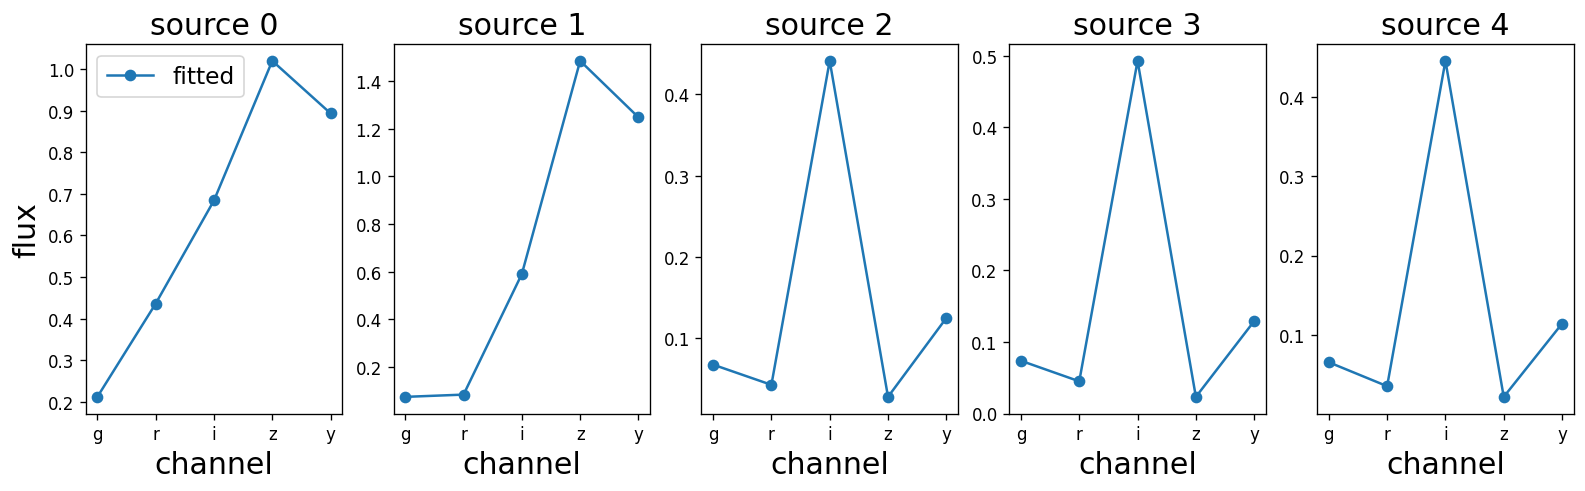

In [18]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(16,4),dpi=120)
for i, ax in enumerate(axes):
    if i == 0:
        ax.plot(scene.sources[i].spectrum(), 'o-',label = "fitted")
        ax.set_ylabel("flux", fontsize = 18)
        ax.set_xlabel("channel", fontsize = 18)
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels(['g','r','i','z','y'])
        ax.legend(fontsize=14)
    else:
        ax.plot(scene.sources[i].spectrum(), 'o-')
        ax.set_xlabel("channel", fontsize = 18)
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels(['g','r','i','z','y'])
    ax.set_title(f"source {i}", fontsize = 18)
plt.show()